# Introduction

this code is trying to classify movie reviews by using Word2Vec for input embedding, the neural network structure will be CNN


# Import Section

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
import torch
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.models import Word2Vec
import gensim
from tqdm import tqdm
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from collections import Counter
from sklearn.metrics import accuracy_score

# Load Data and Preprocessing (tokenization, train test split)

In [ ]:
df = pd.read_csv("movie_review_RT50K.csv")
print(df.shape)
df.head(3)

(50000, 2)


,content,sentiment
0,"Compelling in fits and starts, actor-director ...",0
1,Quite simply one of the finest comic romances ...,1
2,A psychological thriller that dangles over the...,0


check class Balance, 25k class 0 and 25k class 1

In [ ]:
Counter(df.sentiment)

Counter({0: 25000, 1: 25000})

tokenization

In [ ]:
df['tokenized_text'] = [simple_preprocess(text, deacc=True) for text in df['content']] 
df['tokenized_text'].head(5)

0    [compelling, in, fits, and, starts, actor, dir...
1    [quite, simply, one, of, the, finest, comic, r...
2    [psychological, thriller, that, dangles, over,...
3    [the, general, is, something, of, salute, to, ...
4    [you, think, that, movie, that, opens, with, g...
Name: tokenized_text, dtype: object

stemming

In [ ]:
porter_stemmer = PorterStemmer()
df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df['tokenized_text'] ]
df['stemmed_tokens'].head(5)

0    [compel, in, fit, and, start, actor, director,...
1    [quit, simpli, on, of, the, finest, comic, rom...
2    [psycholog, thriller, that, dangl, over, the, ...
3    [the, gener, is, someth, of, salut, to, boorma...
4    [you, think, that, movi, that, open, with, gra...
Name: stemmed_tokens, dtype: object

In [ ]:
df.head(5)

,content,sentiment,tokenized_text,stemmed_tokens
0,"Compelling in fits and starts, actor-director ...",0,"[compelling, in, fits, and, starts, actor, dir...","[compel, in, fit, and, start, actor, director,..."
1,Quite simply one of the finest comic romances ...,1,"[quite, simply, one, of, the, finest, comic, r...","[quit, simpli, on, of, the, finest, comic, rom..."
2,A psychological thriller that dangles over the...,0,"[psychological, thriller, that, dangles, over,...","[psycholog, thriller, that, dangl, over, the, ..."
3,The General is something of a salute to Boorma...,1,"[the, general, is, something, of, salute, to, ...","[the, gener, is, someth, of, salut, to, boorma..."
4,You'd think that a movie that opens with a gra...,0,"[you, think, that, movie, that, opens, with, g...","[you, think, that, movi, that, open, with, gra..."


train test split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df[['content','tokenized_text','stemmed_tokens']], 
                                                    df['sentiment'], 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=2021)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 3)
(40000,)
(10000, 3)
(10000,)


train validation split

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                    Y_train, 
                                                    shuffle=True,
                                                    test_size=0.1, 
                                                    random_state=2021)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(36000, 3)
(36000,)
(4000, 3)
(4000,)


# Create Word2Vec Model

you need to first create a file path 'w2c/models' in your working directory

In [ ]:
OUTPUT_FOLDER='w2c/'
size = 500 #embedding length
window = 3 #Maximum distance between the current and predicted word within a sentence.
min_count = 1 # Ignores  words with counts lower than this.
workers = 2
sg = 1 # sg Training algorithm: 1 for skip-gram; otherwise CBOW.


def make_word2vec_model(df, padding=True, sg=1, min_count=1, size=500, workers=2, window=3):
    if  padding:
        temp_df = pd.Series(df['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = df['stemmed_tokens']
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '.model'

    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model

# Train Word2vec model, word2vec_file is only a str
w2vmodel = make_word2vec_model(df, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

# change input to token id vector and tensor

create a function that change word to vectors in tensor form

In [ ]:
#get the maximum length
max_sen_len = df.stemmed_tokens.map(len).max()
print('max length of stemmed tokens',max_sen_len)

#get the padding word index
padding_idx = w2vmodel.wv.vocab['pad'].index
print('padding index',padding_idx)

#generate the torch tensor of the sentence, using token id, pad id of the 'pad' all the way to the end of 390, which is the longest sentence
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            print('unknown word:',word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    
    return torch.tensor(padded_X, dtype=torch.long).view(1, -1)


max length of stemmed tokens 50
padding index 2571


create a function to change target into tensor

In [ ]:
def make_target(target):    
    if target == 0:
        return torch.tensor([0], dtype=torch.long)
    elif target == 1:
        return torch.tensor([1], dtype=torch.long)
make_target(1)

tensor([1])

test the shape of a sentence and its format

In [ ]:
curTest = make_word2vec_vector_cnn(df['stemmed_tokens'][0])
curTest.shape

torch.Size([1, 50])

# create classifier

In [ ]:
VOCAB_SIZE = len(w2vmodel.wv.vocab)  #24832
print('vocabulary size',VOCAB_SIZE)

vocabulary size 24832


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:
NUM_CLASSES = 2
EMBEDDING_SIZE = 500
NUM_FILTERS = 10


class CNNModel(nn.Module):

    def __init__(self, num_classes, window_sizes=(1,2,3,5)):
        super(CNNModel, self).__init__()        
        weights = w2vmodel.wv
        
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        self.convs = nn.ModuleList([
              nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
              for window_size in window_sizes
        ])
        self.fc1=nn.Linear(NUM_FILTERS * len(window_sizes),100 )
        self.fc2 = nn.Linear(100, num_classes)
        self.bn = nn.BatchNorm1d(num_features=100)
        self.drop= nn.Dropout(0.2)

        # self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)


    def forward(self, x):
        x = self.embedding(x) # [Batch, Text, Eembbeding]#size ([1, 50, 500])

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)   #size ([1, 1,50, 500])

        xs = []

        for conv in self.convs:
            x2=conv(x)
            x2 = torch.tanh(x2)
            x2 = torch.squeeze(x2, -1)          #you can only squeeze if you know for sure that dimension is 1
            x2 = F.max_pool1d(x2, x2.size(2))   #max_pool1d can only take in 3 dimensional data, thats why you need to squeeze
            xs.append(x2)

        x = torch.cat(xs, 2)

        # Feed Forward layer
        x = x.view(x.size(0), -1) #only keep the batch

        

        x=torch.relu(self.bn(self.fc1(x)))
        x=self.drop(x)
        x=(self.fc2(x))        
        res = F.softmax(x, dim = 1)


        # logits =self.fc(x)
        # res = F.softmax(logits, dim = 1)

        return res

#the vectors created from make_word2vec_vector_cnn is already on gpu

simple testing to make sure everything works for a single sentence, without training first

In [ ]:
curTest = make_word2vec_vector_cnn(df['stemmed_tokens'][1])
model = CNNModel(num_classes=NUM_CLASSES)
tempRes=model(curTest)

print(df.content[1])
print('sentiment predicted',torch.argmax(tempRes,dim=-1))

Quite simply one of the finest comic romances ever made.
sentiment predicted tensor([1])


# Initial probe of Training and testing (no need to run) 

In [ ]:
BATCH_SIZE=64
NUM_CLASSES = 2

model = CNNModel(num_classes=NUM_CLASSES)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-3)
num_epochs = 20

model.train()   #to speicify the training condition

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))

    train_loss = 0

    for i in range(0,len(X_train),BATCH_SIZE):

        model.zero_grad()
        tempX=[]
        tempY=[]

        for j in range(i,min(i+BATCH_SIZE,len(X_train))):
          bow_vec = make_word2vec_vector_cnn(X_train.iloc[j]['stemmed_tokens'])
          tempX.append(bow_vec)
          tempY.append(make_target(Y_train.iloc[j]))
        
        tempX=torch.cat(tempX,dim=-2).to(device)
        tempY=torch.cat(tempY,dim=0).to(device)

        res = model(tempX)

        loss = loss_function(res, tempY)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
                

    print('loss',str(round(train_loss / len(X_train),5)))
    train_loss = 0




Epoch1
loss 0.00935
Epoch2
loss 0.00871
Epoch3
loss 0.00849
Epoch4
loss 0.00833
Epoch5
loss 0.00821
Epoch6
loss 0.00811
Epoch7
loss 0.00803
Epoch8
loss 0.00796
Epoch9
loss 0.00788
Epoch10
loss 0.00782
Epoch11
loss 0.00776
Epoch12
loss 0.00773
Epoch13
loss 0.00776
Epoch14
loss 0.00775
Epoch15
loss 0.00777
Epoch16
loss 0.0077
Epoch17
loss 0.00767
Epoch18
loss 0.00765
Epoch19
loss 0.00761
Epoch20
loss 0.00759


In [ ]:

y_pred = []
y_test = []


model.eval()
with torch.no_grad():

     for i in tqdm(range(len(X_test))):

        bow_vec = make_word2vec_vector_cnn(X_test.iloc[i]['stemmed_tokens']).to(device)
        res = model(bow_vec)

        _, predicted = torch.max(res.data, 1)

        y_pred.append(predicted.cpu().numpy()[0])
        y_test.append(make_target(Y_test.iloc[i]).numpy()[0])


print()
print(classification_report(y_test,y_pred))


100%|██████████| 10000/10000 [00:09<00:00, 1089.53it/s]


              precision    recall  f1-score   support

           0       0.78      0.70      0.74      5028
           1       0.73      0.79      0.76      4972

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



# Change input into vector forms beforehand for quick training and testing

In [ ]:
def changeInput(X,Y):
  X_Vec=list([])
  Y_Vec=list([])

  for i in range(len(X)):
    bow_vec = make_word2vec_vector_cnn(X.iloc[i]['stemmed_tokens'])
    X_Vec.append(bow_vec)
    Y_Vec.append(make_target(Y.iloc[i]))
          
  X_Vec=torch.cat(X_Vec,dim=-2)
  Y_Vec=torch.cat(Y_Vec,dim=0)

  return X_Vec,Y_Vec

X_train_Vec,Y_train_Vec=changeInput(X_train,Y_train)
print(X_train_Vec.shape)
print(Y_train_Vec.shape)

X_test_Vec,Y_test_Vec=changeInput(X_test,Y_test)
print(X_test_Vec.shape)
print(Y_test_Vec.shape)

X_valid_Vec,Y_valid_Vec=changeInput(X_valid,Y_valid)
print(X_valid_Vec.shape)
print(Y_valid_Vec.shape)

torch.Size([36000, 50])
torch.Size([36000])
torch.Size([10000, 50])
torch.Size([10000])
torch.Size([4000, 50])
torch.Size([4000])


def a method computing validation statistics

In [ ]:

def getValid():
  
  model.eval()
  with torch.no_grad():
    
    BATCH_SIZE=200
    temp_pred=[]
    validLoss=0

    for i in range(0,len(X_valid),BATCH_SIZE):

      endIndex=min(i+BATCH_SIZE,len(X_valid))
      tempX=X_valid_Vec[i:endIndex].to(device)
      tempY=Y_valid_Vec[i:endIndex].to(device)
      res = model(tempX)

      _, predicted = torch.max(res.data, 1)
      temp_pred.extend(list(predicted.cpu().numpy())) 

      loss = loss_function(res, tempY)
      validLoss += loss.item()


    validLoss=round(validLoss /len(X_valid),5)
    validAcc=round(accuracy_score(Y_valid, temp_pred),3)

  return validLoss,validAcc

        


In [ ]:
BATCH_SIZE=100
NUM_CLASSES = 2

model = CNNModel(num_classes=NUM_CLASSES)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
num_epochs = 100

train_loss=[]
val_loss=[]
val_acc=[]

model.train()   #to speicify the training condition

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'finished')
    trainLoss = 0

    for i in range(0,len(X_train),BATCH_SIZE):

        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,len(X_train))
        tempX=X_train_Vec[i:endIndex].to(device)
        tempY=Y_train_Vec[i:endIndex].to(device)

        res = model(tempX)

        loss = loss_function(res, tempY)
        trainLoss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
                
    
    trainLoss=round(trainLoss / len(X_train),5)      
    validLoss,validAcc=getValid()

    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)

    model.train()    


Epoch1 finished
Epoch2 finished
Epoch3 finished
Epoch4 finished
Epoch5 finished
Epoch6 finished
Epoch7 finished
Epoch8 finished
Epoch9 finished
Epoch10 finished
Epoch11 finished
Epoch12 finished
Epoch13 finished
Epoch14 finished
Epoch15 finished
Epoch16 finished
Epoch17 finished
Epoch18 finished
Epoch19 finished
Epoch20 finished
Epoch21 finished
Epoch22 finished
Epoch23 finished
Epoch24 finished
Epoch25 finished
Epoch26 finished
Epoch27 finished
Epoch28 finished
Epoch29 finished
Epoch30 finished
Epoch31 finished
Epoch32 finished
Epoch33 finished
Epoch34 finished
Epoch35 finished
Epoch36 finished
Epoch37 finished
Epoch38 finished
Epoch39 finished
Epoch40 finished
Epoch41 finished
Epoch42 finished
Epoch43 finished
Epoch44 finished
Epoch45 finished
Epoch46 finished
Epoch47 finished
Epoch48 finished
Epoch49 finished
Epoch50 finished
Epoch51 finished
Epoch52 finished
Epoch53 finished
Epoch54 finished
Epoch55 finished
Epoch56 finished
Epoch57 finished
Epoch58 finished
Epoch59 finished
Epoch6

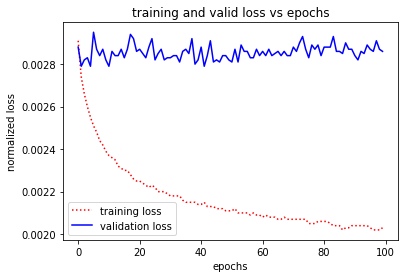

In [ ]:
epoch_list=[i for i in range(0,100)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()



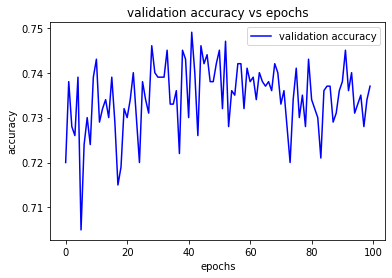

In [ ]:
epoch_list=[i for i in range(0,100)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


test accuracy

In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()
with torch.no_grad():
     for i in tqdm(range(0,len(X_test),BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,len(X_test))
        tempX=X_test_Vec[i:endIndex].to(device)
        res = model(tempX)
        _, predicted = torch.max(res.data, 1)
        y_pred.extend(list(predicted.cpu().numpy()))        

print()
print(classification_report(Y_test,y_pred))



100%|██████████| 50/50 [00:00<00:00, 827.20it/s]


              precision    recall  f1-score   support

           0       0.75      0.72      0.73      5028
           1       0.73      0.76      0.74      4972

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



train accuracy

In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()
with torch.no_grad():      
     for i in tqdm(range(0,len(X_train),BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,len(X_train))
        tempX=X_train_Vec[i:endIndex].to(device)
        res = model(tempX)
        _, predicted = torch.max(res.data, 1) 
        y_pred.extend(list(predicted.cpu().numpy()))        
print()
print(classification_report(Y_train,y_pred))



100%|██████████| 180/180 [00:00<00:00, 811.23it/s]


              precision    recall  f1-score   support

           0       0.90      0.90      0.90     17974
           1       0.90      0.90      0.90     18026

    accuracy                           0.90     36000
   macro avg       0.90      0.90      0.90     36000
weighted avg       0.90      0.90      0.90     36000

